In [42]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

def load_data(data_folder, test_size=0.2, random_state=42):
    """
    加载 `feature_matrix.npy` 和 `labels.npy` 数据，并划分训练集和测试集。

    参数：
    - data_folder: 存放数据的文件夹路径
    - test_size: 测试集比例 (默认 20%)
    - random_state: 随机种子，保证可复现性

    返回：
    - X_train: 训练集特征，形状 (train_batches, num_windows, 15, num_channels)
    - X_test: 测试集特征，形状 (test_batches, num_windows, 15, num_channels)
    - y_train: 训练集标签，形状 (train_batches,)
    - y_test: 测试集标签，形状 (test_batches,)
    """
    # **加载数据**
    feature_path = os.path.join(data_folder, "feature_matrix.npy")
    label_path = os.path.join(data_folder, "labels.npy")

    if not os.path.exists(feature_path) or not os.path.exists(label_path):
        raise FileNotFoundError("特征文件或标签文件未找到，请检查路径！")

    X = np.load(feature_path)  # 形状 (num_batches, num_windows, 15, num_channels)
    y = np.load(label_path)  # 形状 (num_batches,)

    # **数据基本信息**
    print(f"Loaded features from {feature_path}, shape: {X.shape}")
    print(f"Loaded labels from {label_path}, shape: {y.shape}")

    # **划分训练集和测试集**
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state
        )

    # **打印数据划分信息**
    print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Testing set: X_test: {X_test.shape}, y_test: {y_test.shape}")

    return X_train, X_test, y_train, y_test

# **使用示例**
data_folder = r"E:\MSC\Spring\AML\GestureLink\data\G\windowed_data"
X_train, X_test, y_train, y_test = load_data(data_folder)



Loaded features from E:\MSC\Spring\AML\GestureLink\data\G\windowed_data\feature_matrix.npy, shape: (390, 59, 15, 10)
Loaded labels from E:\MSC\Spring\AML\GestureLink\data\G\windowed_data\labels.npy, shape: (390,)
Training set: X_train: (312, 59, 15, 10), y_train: (312,)
Testing set: X_test: (78, 59, 15, 10), y_test: (78,)


In [83]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

def load_and_split_data(data_folder, selected_labels=[1, 2, 3], test_size=0.2, random_state=42):
    """
    加载 `feature_matrix.npy` 和 `labels.npy` 数据，筛选标签为指定类别的数据，并划分训练集和测试集。

    参数：
    - data_folder: 存放数据的文件夹路径
    - selected_labels: 需要提取的标签列表
    - test_size: 测试集比例（默认 20%）
    - random_state: 随机种子，保证可复现

    返回：
    - X_train, X_test: 训练和测试集的特征数据
    - y_train, y_test: 训练和测试集的标签数据
    """
    # **加载数据**
    feature_path = os.path.join(data_folder, "feature_matrix.npy")
    label_path = os.path.join(data_folder, "labels.npy")

    if not os.path.exists(feature_path) or not os.path.exists(label_path):
        raise FileNotFoundError("特征文件或标签文件未找到，请检查路径！")

    X = np.load(feature_path)  # 形状 (num_batches, num_windows, 15, num_channels)
    y = np.load(label_path)  # 形状 (num_batches,)

    # **数据基本信息**
    print(f"Loaded features from {feature_path}, shape: {X.shape}")
    print(f"Loaded labels from {label_path}, shape: {y.shape}")

    # **筛选出指定标签的数据**
    mask = np.isin(y, selected_labels)  # 创建布尔掩码
    X_filtered = X[mask]  # 选取符合标签的 X
    y_filtered = y[mask]  # 选取符合标签的 y

    # **划分训练集和测试集**
    X_train, X_test, y_train, y_test = train_test_split(
        X_filtered, y_filtered, test_size=test_size, random_state=random_state, stratify=y_filtered
    )

    # **打印划分后数据的信息**
    print(f"Train set: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Test set: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    return X_train, X_test, y_train, y_test

# **使用示例**
data_folder = r"E:\MSC\Spring\AML\GestureLink\data\G\windowed_data"
X_train, X_test, y_train, y_test = load_and_split_data(data_folder, selected_labels=[1, 2, 3])


Loaded features from E:\MSC\Spring\AML\GestureLink\data\G\windowed_data\feature_matrix.npy, shape: (390, 59, 15, 10)
Loaded labels from E:\MSC\Spring\AML\GestureLink\data\G\windowed_data\labels.npy, shape: (390,)
Train set: X_train shape: (36, 59, 15, 10), y_train shape: (36,)
Test set: X_test shape: (9, 59, 15, 10), y_test shape: (9,)


In [84]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
X_train = X_train[:,:,:10,:]
X_test = X_test[:,:,:10,:]
# **检查 NaN 并清理**
print(f"NaNs in X_train: {np.isnan(X_train).sum()} / {X_train.size}")
print(f"NaNs in X_test: {np.isnan(X_test).sum()} / {X_test.size}")

# **修正布尔索引，确保匹配数据形状**
mask_train = ~np.isnan(X_train).any(axis=(1, 2, 3))  # 在所有轴上检测 NaN
mask_test = ~np.isnan(X_test).any(axis=(1, 2, 3))  # 适用于4D数据 (batch, window, 15, 10)

# **过滤 NaN**
X_train, y_train = X_train[mask_train], y_train[mask_train]
X_test, y_test = X_test[mask_test], y_test[mask_test]

# **再次检查 NaN**
print(f"NaNs in X_train (after cleaning): {np.isnan(X_train).sum()} / {X_train.size}")
print(f"NaNs in X_test (after cleaning): {np.isnan(X_test).sum()} / {X_test.size}")

# **KNN 训练**
knn = KNeighborsClassifier(n_neighbors=5)  # k=5
X_train_flatten = X_train.reshape(X_train.shape[0], -1)  # (batch, 15*10)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)  # (batch, 15*10)

knn.fit(X_train_flatten, y_train)

# **KNN 预测**
y_pred = knn.predict(X_test_flatten)

# **评估**
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN 测试集准确率: {accuracy:.2f}")

# **打印分类报告**
print("分类报告:\n", classification_report(y_test, y_pred))


NaNs in X_train: 27472 / 212400
NaNs in X_test: 6608 / 53100
NaNs in X_train (after cleaning): 0 / 35400
NaNs in X_test (after cleaning): 0 / 11800
KNN 测试集准确率: 0.50
分类报告:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



d:\MY_SOFTWARE\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\MY_SOFTWARE\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\MY_SOFTWARE\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [46]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# **加载数据**
data_folder = r"E:\MSC\Spring\AML\GestureLink\data\G\windowed_data"
X_train, X_test, y_train, y_test = load_data(data_folder)
X_train = np.nan_to_num(X_train, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)
y_train = np.nan_to_num(y_train, nan = 0.0)
y_test = np.nan_to_num(y_test, nan = 0.0)
# **获取数据形状**
num_batches = X_train.shape[0]  # batch 维度
num_windows = X_train.shape[1]  # 时间步（窗口数 59）
num_features = X_train.shape[2]  # 特征数（15）
num_channels = X_train.shape[3]  # 通道数（1）

# **检测类别数量**
unique_classes = np.unique(y_train)
num_classes = len(unique_classes)  # 确保类别数正确

print(f"Corrected Classes: {num_classes}, Batches: {num_batches}, Windows: {num_windows}, Features: {num_features}, Channels: {num_channels}")

# **保持 X 形状**
X_train = X_train.reshape(num_batches, num_windows, num_features, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_windows, num_features, num_channels)
X_train = X_train[:,:,:4,:1]
X_test = X_test[:,:,:4,:1]



# print(X_train.shape)

num_features = X_train.shape[2] 
num_channels = X_train.shape[3]
# **标签编码**
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)  # 转换成 0,1,2
y_test = encoder.transform(y_test)

# **转换为 One-Hot**
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")  # (batch, 59, 15, 1) (batch, 3)
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")  # (batch, 59, 15, 1) (batch, 3)

# print(num_features)
# **构建 LSTM 处理通道的模型**
model = Sequential([
    TimeDistributed(Conv1D(filters=16, kernel_size=3, activation='relu'), input_shape=(num_windows, num_features, num_channels)),  # 1D CNN 提取局部特征
    TimeDistributed(Flatten()),  # 压缩通道
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # 多分类
])

# **编译模型**
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# **训练模型**
epochs = 200
batch_size = 8

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

# **测试模型**
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **计算准确率**
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy: {accuracy:.4f}")

# **保存模型**
# model.save("rnn_emg_model.h5")
# print("Model saved as rnn_emg_model.h5")


Loaded features from E:\MSC\Spring\AML\GestureLink\data\G\windowed_data\feature_matrix.npy, shape: (390, 59, 15, 10)
Loaded labels from E:\MSC\Spring\AML\GestureLink\data\G\windowed_data\labels.npy, shape: (390,)
Training set: X_train: (312, 59, 15, 10), y_train: (312,)
Testing set: X_test: (78, 59, 15, 10), y_test: (78,)
Corrected Classes: 26, Batches: 312, Windows: 59, Features: 15, Channels: 10
X_train shape: (312, 59, 4, 1), y_train shape: (312, 26)
X_test shape: (78, 59, 4, 1), y_test shape: (78, 26)
Epoch 1/200
39/39 [==============================] - 18s 190ms/step - loss: 3.2696 - accuracy: 0.0417 - val_loss: 3.2596 - val_accuracy: 0.0385
Epoch 2/200
39/39 [==============================] - 5s 117ms/step - loss: 3.2609 - accuracy: 0.0160 - val_loss: 3.2609 - val_accuracy: 0.0256
Epoch 3/200
39/39 [==============================] - 5s 121ms/step - loss: 3.2596 - accuracy: 0.0353 - val_loss: 3.2640 - val_accuracy: 0.0513
Epoch 4/200
39/39 [==============================] - 5s 125

KeyboardInterrupt: 

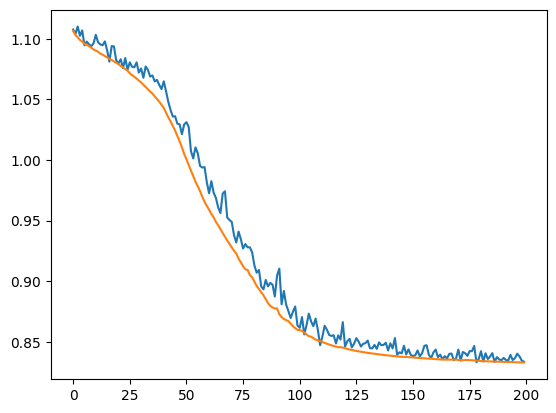

In [62]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [7]:
y_test


array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [20]:
X_train.shape

(36, 59, 15, 1)